In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### Pipeline psuedo code
    n = look back window
    k = number of PCs to keep

    for each time point t:
        p = number of stocks in investable universe at time t
        Define an n x p feature matrix X (lagged returns)

        Perform PCA on X
        Keep the first k PCs in an n x k matrix Z

    for each stock s in the investable universe at time t:
        Define an n x 1 outcome vector y (future returns of stock s)
        Perform a linear regression of y on Z
        Predict y for stock s at time t+1

## Data Preparation

In [9]:
returns = pd.read_pickle("./Data/returns.pkl")
returns = returns.iloc[1:]

In [10]:
len(returns.loc['2007':'2021'].index)

3627

In [11]:
drop_columns = []

for col in returns.columns:
    if returns[col].isnull().all() == True:
        drop_columns.append(col)
        
returns.drop(columns=drop_columns, inplace=True)

## Pipeline

In [12]:
def get_investable(t, n):
    """"Find stocks in investable universe at time t+1
    (stocks in the S&P500 that have prices recorded for the last n days)"""
    
    df_investable = returns.copy(deep = True).sort_index(ascending = False)
    
    #add 1 date to get the test features in investable
    t = t + pd.DateOffset(1)
    n += 1
    
    #if t is now a non-trading day, advance until we reach a valid trading day
    while t not in df_investable.index:
        t = t + pd.DateOffset(1)
    
    t_index = df_investable.index.get_loc(t)
    
    #take n_rows worth of data upto time specified
    df_investable = df_investable.iloc[t_index:t_index + n]
    
    #find all stocks that exist in the S&P at this time period
    investable_universe = []
    for col in df_investable.columns:
        if ~df_investable[col].iloc[:n].isna().any():
            investable_universe.append(col)
        
    df_investable = df_investable[investable_universe]
    
    return df_investable

In [13]:
def apply_PCA(inv, k):
    X = inv.iloc[1:, :]
    pca = PCA(n_components = k) 
    inv_scaled = sklearn.preprocessing.StandardScaler().fit_transform(X)   
    principal_components = pca.fit_transform(inv_scaled)

    df = pd.DataFrame(data = principal_components)
    
    #For explained variance table
    components = pca.components_
    component_explained_var = pca.explained_variance_ratio_ * 100
    
    comp_names = ['PCA' + str(i) for i in range(1, len(component_explained_var) + 1)]

    pca_results = pd.DataFrame(data = component_explained_var, index = comp_names)
    pca_results.columns = ['Explained variance (%)']
    pca_results['Explained variance (%)'] = pca_results['Explained variance (%)'].round(2)
    
    return df

In [14]:
def define_y(inv, stock):
    y = inv[[stock]].iloc[:-1]
    
    return y

In [15]:
def train_test(X, y):
    X_train = X.iloc[1:, :]
    X_test = X.iloc[0:1, :]
    y_train = y.iloc[1:]
    y_test = y.iloc[0:1]
    
    return X_train, y_train, X_test, y_test

In [16]:
def model_fit(X_train, y_train):
    model = RandomForestRegressor(
            n_estimators = 200)
    model.fit(X_train, y_train)
    
    return model

In [17]:
def model_predict(model, X_test):
    yhat = model.predict(X_test)
    
    return yhat

In [18]:
def predict_returns(t, n, k, model, refit = True):
    inv = get_investable(t, n)
    X = apply_PCA(inv, k)
    
    returns_t = pd.DataFrame(index = inv.columns, columns = ['Pred', 'Actual'])
    
    for stock in inv.columns:
        y = define_y(inv, stock)
        X_train, y_train, X_test, y_test = train_test(X, y)
        
        if refit:
            model = model_fit(X_train, y_train)
            
        yhat = model_predict(model, X_test)[0]
        returns_t['Pred'].loc[stock] = yhat
        returns_t['Actual'].loc[stock] = y_test.values[0][0]
    
    return returns_t, model

In [19]:
def rank_stocks(returns, num_stocks):
    pred_returns = returns.sort_values(by = 'Pred', ascending = False)
    topn = pred_returns.head(num_stocks)
    botn = pred_returns.tail(num_stocks)
    
    return topn, botn

In [20]:
def portfolio_return(topn, botn, returns):
    return_t = topn['Actual'].mean() - botn['Actual'].mean()
    
    return return_t

In [22]:
def pipeline(n, k, num_stocks):

    time_range = returns.loc['2007':'2021'].index
    returns_monthly = returns.resample('M').mean()
    
    for i in range(len(time_range)):
        if time_range[i] in returns_monthly.index:
            time_range = time_range[i:]
            break
    
    portfolio = pd.DataFrame(index = time_range, columns = ['Portfolio Return'])
    current_model = Sequential()
    
    count = 0
    for t in time_range[:-1]:
        if t in returns_monthly.index:
            pred_actual, current_model = predict_returns(t, n, k, current_model, refit = True)
        else:
            pred_actual, current_model = predict_returns(t, n, k, current_model, refit = False)
        
        topn, botn = rank_stocks(pred_actual, num_stocks)
        return_t = portfolio_return(topn, botn, pred_actual)
        t_index = time_range.get_loc(t) + 1
        portfolio['Portfolio Return'].loc[time_range[t_index]] = return_t
        
        count +=1
        print(f'{(count/len(time_range))*100:.2f}% complete')
    
    return portfolio

In [23]:
portfolio = pipeline(200, 20, 5)

0.03% complete
0.06% complete
0.08% complete
0.11% complete
0.14% complete
0.17% complete
0.19% complete
0.22% complete
0.25% complete
0.28% complete
0.30% complete
0.33% complete
0.36% complete
0.39% complete
0.42% complete
0.44% complete
0.47% complete
0.50% complete
0.53% complete
0.55% complete
0.58% complete
0.61% complete
0.64% complete
0.67% complete
0.69% complete
0.72% complete
0.75% complete
0.78% complete
0.80% complete
0.83% complete
0.86% complete
0.89% complete
0.91% complete
0.94% complete
0.97% complete
1.00% complete
1.03% complete
1.05% complete
1.08% complete
1.11% complete
1.14% complete
1.16% complete
1.19% complete
1.22% complete
1.25% complete
1.27% complete
1.30% complete
1.33% complete
1.36% complete
1.39% complete
1.41% complete
1.44% complete
1.47% complete
1.50% complete
1.52% complete
1.55% complete
1.58% complete
1.61% complete
1.64% complete
1.66% complete
1.69% complete
1.72% complete
1.75% complete
1.77% complete
1.80% complete
1.83% complete
1.86% comp

14.86% complete
14.88% complete
14.91% complete
14.94% complete
14.97% complete
14.99% complete
15.02% complete
15.05% complete
15.08% complete
15.11% complete
15.13% complete
15.16% complete
15.19% complete
15.22% complete
15.24% complete
15.27% complete
15.30% complete
15.33% complete
15.35% complete
15.38% complete
15.41% complete
15.44% complete
15.47% complete
15.49% complete
15.52% complete
15.55% complete
15.58% complete
15.60% complete
15.63% complete
15.66% complete
15.69% complete
15.72% complete
15.74% complete
15.77% complete
15.80% complete
15.83% complete
15.85% complete
15.88% complete
15.91% complete
15.94% complete
15.96% complete
15.99% complete
16.02% complete
16.05% complete
16.08% complete
16.10% complete
16.13% complete
16.16% complete
16.19% complete
16.21% complete
16.24% complete
16.27% complete
16.30% complete
16.32% complete
16.35% complete
16.38% complete
16.41% complete
16.44% complete
16.46% complete
16.49% complete
16.52% complete
16.55% complete
16.57% c

29.07% complete
29.10% complete
29.13% complete
29.16% complete
29.19% complete
29.21% complete
29.24% complete
29.27% complete
29.30% complete
29.32% complete
29.35% complete
29.38% complete
29.41% complete
29.43% complete
29.46% complete
29.49% complete
29.52% complete
29.55% complete
29.57% complete
29.60% complete
29.63% complete
29.66% complete
29.68% complete
29.71% complete
29.74% complete
29.77% complete
29.79% complete
29.82% complete
29.85% complete
29.88% complete
29.91% complete
29.93% complete
29.96% complete
29.99% complete
30.02% complete
30.04% complete
30.07% complete
30.10% complete
30.13% complete
30.16% complete
30.18% complete
30.21% complete
30.24% complete
30.27% complete
30.29% complete
30.32% complete
30.35% complete
30.38% complete
30.40% complete
30.43% complete
30.46% complete
30.49% complete
30.52% complete
30.54% complete
30.57% complete
30.60% complete
30.63% complete
30.65% complete
30.68% complete
30.71% complete
30.74% complete
30.76% complete
30.79% c

43.29% complete
43.32% complete
43.35% complete
43.38% complete
43.40% complete
43.43% complete
43.46% complete
43.49% complete
43.51% complete
43.54% complete
43.57% complete
43.60% complete
43.63% complete
43.65% complete
43.68% complete
43.71% complete
43.74% complete
43.76% complete
43.79% complete
43.82% complete
43.85% complete
43.87% complete
43.90% complete
43.93% complete
43.96% complete
43.99% complete
44.01% complete
44.04% complete
44.07% complete
44.10% complete
44.12% complete
44.15% complete
44.18% complete
44.21% complete
44.24% complete
44.26% complete
44.29% complete
44.32% complete
44.35% complete
44.37% complete
44.40% complete
44.43% complete
44.46% complete
44.48% complete
44.51% complete
44.54% complete
44.57% complete
44.60% complete
44.62% complete
44.65% complete
44.68% complete
44.71% complete
44.73% complete
44.76% complete
44.79% complete
44.82% complete
44.84% complete
44.87% complete
44.90% complete
44.93% complete
44.96% complete
44.98% complete
45.01% c

57.51% complete
57.54% complete
57.57% complete
57.59% complete
57.62% complete
57.65% complete
57.68% complete
57.71% complete
57.73% complete
57.76% complete
57.79% complete
57.82% complete
57.84% complete
57.87% complete
57.90% complete
57.93% complete
57.95% complete
57.98% complete
58.01% complete
58.04% complete
58.07% complete
58.09% complete
58.12% complete
58.15% complete
58.18% complete
58.20% complete
58.23% complete
58.26% complete
58.29% complete
58.31% complete
58.34% complete
58.37% complete
58.40% complete
58.43% complete
58.45% complete
58.48% complete
58.51% complete
58.54% complete
58.56% complete
58.59% complete
58.62% complete
58.65% complete
58.68% complete
58.70% complete
58.73% complete
58.76% complete
58.79% complete
58.81% complete
58.84% complete
58.87% complete
58.90% complete
58.92% complete
58.95% complete
58.98% complete
59.01% complete
59.04% complete
59.06% complete
59.09% complete
59.12% complete
59.15% complete
59.17% complete
59.20% complete
59.23% c

71.73% complete
71.76% complete
71.78% complete
71.81% complete
71.84% complete
71.87% complete
71.90% complete
71.92% complete
71.95% complete
71.98% complete
72.01% complete
72.03% complete
72.06% complete
72.09% complete
72.12% complete
72.15% complete
72.17% complete
72.20% complete
72.23% complete
72.26% complete
72.28% complete
72.31% complete
72.34% complete
72.37% complete
72.39% complete
72.42% complete
72.45% complete
72.48% complete
72.51% complete
72.53% complete
72.56% complete
72.59% complete
72.62% complete
72.64% complete
72.67% complete
72.70% complete
72.73% complete
72.75% complete
72.78% complete
72.81% complete
72.84% complete
72.87% complete
72.89% complete
72.92% complete
72.95% complete
72.98% complete
73.00% complete
73.03% complete
73.06% complete
73.09% complete
73.12% complete
73.14% complete
73.17% complete
73.20% complete
73.23% complete
73.25% complete
73.28% complete
73.31% complete
73.34% complete
73.36% complete
73.39% complete
73.42% complete
73.45% c

85.95% complete
85.98% complete
86.00% complete
86.03% complete
86.06% complete
86.09% complete
86.11% complete
86.14% complete
86.17% complete
86.20% complete
86.23% complete
86.25% complete
86.28% complete
86.31% complete
86.34% complete
86.36% complete
86.39% complete
86.42% complete
86.45% complete
86.47% complete
86.50% complete
86.53% complete
86.56% complete
86.59% complete
86.61% complete
86.64% complete
86.67% complete
86.70% complete
86.72% complete
86.75% complete
86.78% complete
86.81% complete
86.83% complete
86.86% complete
86.89% complete
86.92% complete
86.95% complete
86.97% complete
87.00% complete
87.03% complete
87.06% complete
87.08% complete
87.11% complete
87.14% complete
87.17% complete
87.20% complete
87.22% complete
87.25% complete
87.28% complete
87.31% complete
87.33% complete
87.36% complete
87.39% complete
87.42% complete
87.44% complete
87.47% complete
87.50% complete
87.53% complete
87.56% complete
87.58% complete
87.61% complete
87.64% complete
87.67% c

In [24]:
#started at 6:14pm
print(pd.datetime.now())

2021-06-29 13:03:41.711343


In [26]:
portfolio.dropna(inplace = True)

In [27]:
avg_return = portfolio['Portfolio Return'].mean()
print(f'Average return is {avg_return:.4f} %')

Average return is 0.0046 %


In [28]:
portfolio.to_csv('results/RandomForest.csv')

In [29]:
rolling_avg = pd.DataFrame(data = rolling_avg['Portfolio Return'].rolling(252).mean())

In [30]:
rolling_avg.dropna(inplace = True)

In [32]:
rolling_avg.std()/(rolling_avg.shape[0]**0.5)

Portfolio Return    0.000944
dtype: float64

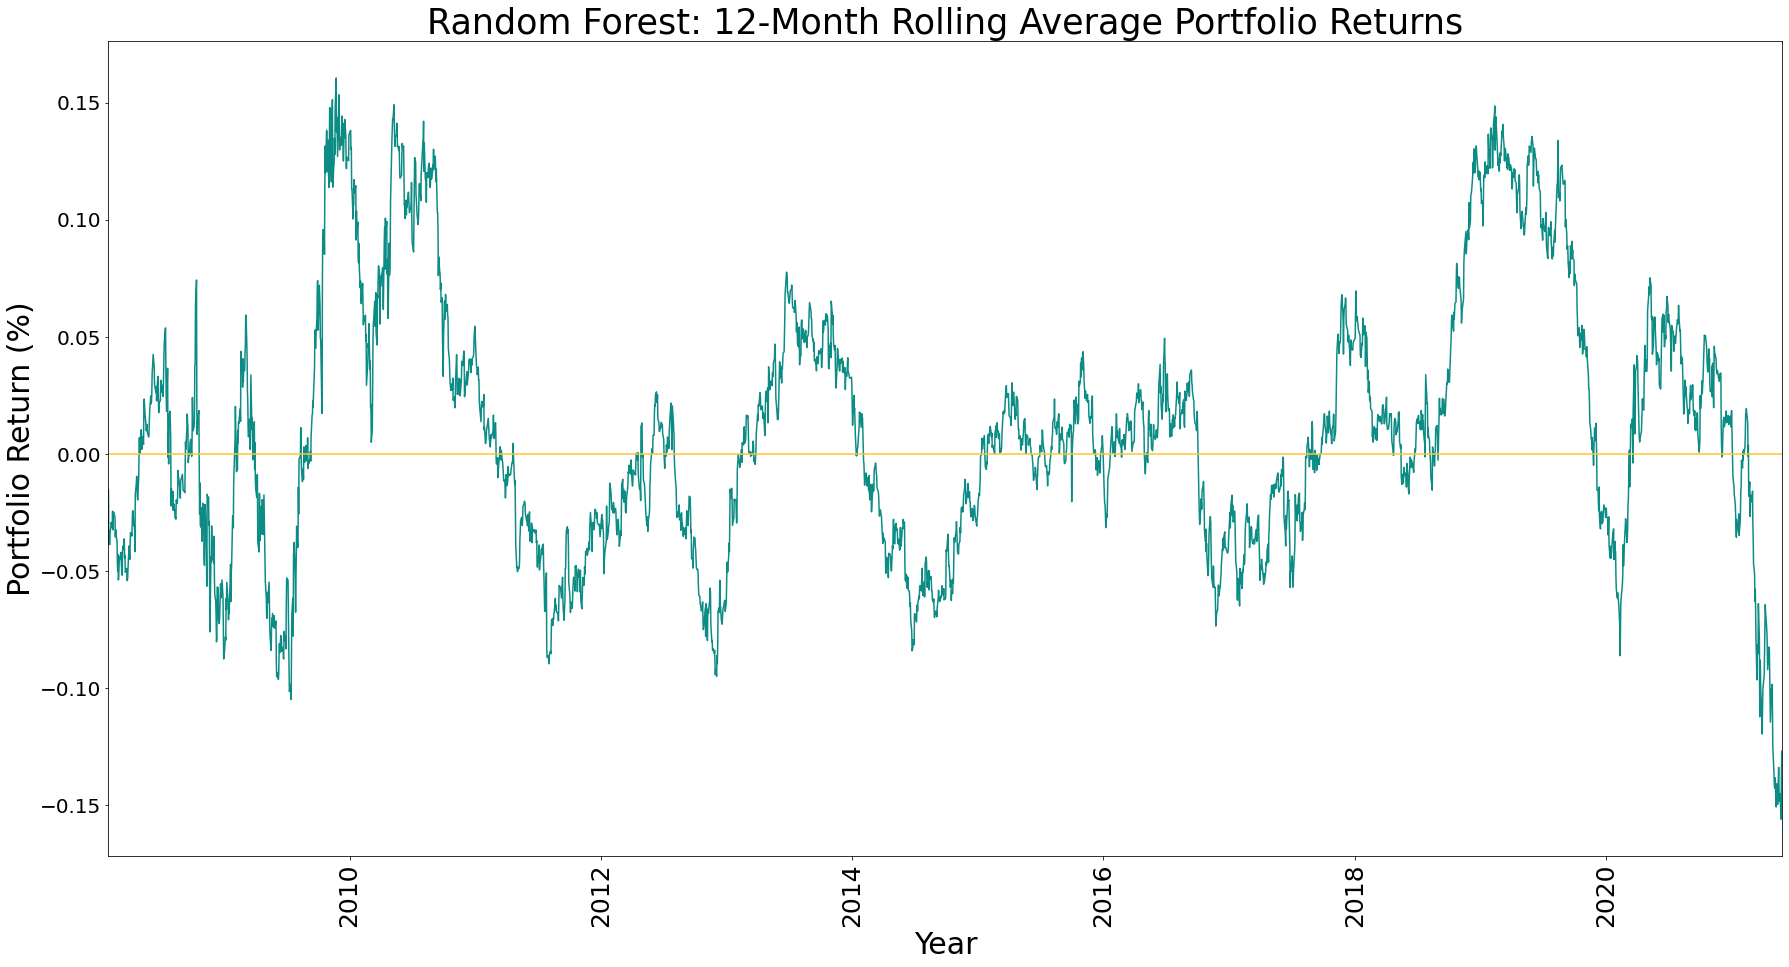

In [31]:
fig, axes = plt.subplots(figsize=(30,15))
sns.lineplot(x=rolling_avg.index, y="Portfolio Return", data=rolling_avg, color = '#0c8c84ff')
plt.xticks(rotation = 'vertical', fontsize = 25)
plt.yticks(fontsize = 20)
axes.set_title('Random Forest: 12-Month Rolling Average Portfolio Returns', fontsize = 35)
axes.set_xlabel('Year', fontsize = 30)
axes.set_ylabel('Portfolio Return (%)', fontsize = 30)
plt.xlim([rolling_avg.index[0], rolling_avg.index[-1]])
plt.axhline(0, color = '#fcc43cff')